In [1]:
import sys
sys.path.append('../')
from mainseq_corrections import niiha_oh_determine

import plot_mainseq_UV_Ha_comparison
reload(plot_mainseq_UV_Ha_comparison)
from plot_mainseq_UV_Ha_comparison import get_flux_from_FAST

import astropy.units as u
from astropy import constants
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 70 * u.km / u.s / u.Mpc, Om0=0.3)

from astropy.io import ascii as asc
from matplotlib import colors
import glob, numpy as np, matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0
CUTOFF_MASS = 6.0

In [2]:
HA = 6562.80
centr_filts = {'NB7':((7045.0/HA - 1) + (7126.0/HA - 1))/2.0, 
               'NB816':8152.0/HA - 1, 'NB921':9193.0/HA - 1, 'NB973':9749.0/HA - 1}

corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',
    guess=False, Reader=asc.FixedWidthTwoLine)

# defining a flux sigma and mass cutoff
good_sig_iis = np.where((corr_tbl['flux_sigma'].data >= CUTOFF_SIGMA) & 
    (corr_tbl['stlr_mass'].data >= CUTOFF_MASS))[0]
corr_tbl = corr_tbl[good_sig_iis]

corrfilts = corr_tbl['filt'].data
corrID = corr_tbl['ID'].data
corrzspec0 = corr_tbl['zspec0'].data
obs_sfrs = corr_tbl['met_dep_sfr'].data
dust_corr_factor = corr_tbl['dust_corr_factor'].data
filt_corr_factor = corr_tbl['filt_corr_factor'].data
nii_ha_corr_factor = corr_tbl['nii_ha_corr_factor'].data

In [3]:
def log_SFR_from_L(y, P2, P1, P0):
    '''z is metallicity'''
    return P0 + P1*y + P2*y**2

def get_LUV(filt_index_haii, ff):
    ID = corrID[filt_index_haii]
    zspec = corrzspec0[filt_index_haii]

    goodz = np.where((zspec >= 0) & (zspec < 9))[0]
    badz  = np.where((zspec <= 0) | (zspec > 9))[0]

    tempz = np.zeros(len(filt_index_haii))
    tempz[goodz] = zspec[goodz]
    tempz[badz] = centr_filts[ff]

    lambda_arr = (1+tempz)*1500

    f_lambda = get_flux_from_FAST(ID, lambda_arr)
    f_nu = f_lambda*(1E-19*(lambda_arr**2*1E-10)/(constants.c.value))
    log_L_nu = np.log10(f_nu*4*np.pi) + \
        2*np.log10(cosmo.luminosity_distance(tempz).to(u.cm).value)

    return log_L_nu

In [4]:
npz_files = np.load(FULL_PATH+'Plots/sfr_metallicity_plot_fit.npz')
Lnu_fit_ch = npz_files['Lnu_fit_ch']

# y = P0 + P1 log(Z/Z_sol) + P2 log(Z/Z_sol)^2
P2, P1, P0 = -1*Lnu_fit_ch

NII6583_Ha = corr_tbl['NII_Ha_ratio'].data * 2.96/(1+2.96)
logOH = niiha_oh_determine(np.log10(NII6583_Ha), 'PP04_N2') - 12   # since this code estimates log(O/H)+12
y = logOH + 3.31

log_SFR_LUV = log_SFR_from_L(y, P2, P1, P0)

LUV = np.zeros(len(corr_tbl))
for ff in ['NB7','NB816','NB921','NB973']:
    filt_index_haii = np.array([x for x in range(len(corr_tbl)) if ff in corrfilts[x]])

    lnu = get_LUV(filt_index_haii, ff)
    LUV[filt_index_haii] = lnu

log_SFR_UV = log_SFR_LUV + LUV

In [5]:
EBV_HA = corr_tbl['EBV'].data
UV_lambda  = 0.15 # units of micron
K_UV       = (2.659*(-2.156 + 1.509/UV_lambda - 0.198/UV_lambda**2
                    + 0.011/UV_lambda**3)+ 4.05)
A_UV = K_UV*0.44*EBV_HA

log_SFR_UV_dustcorr = log_SFR_UV + 0.4*A_UV

In [6]:
def line(x,m,b):
    return m*x+b

def line2(x,a,b):
    return a*(np.log10(7.9e-42) + x) - b

def lee09_eqn10(x):
    # log (SFR (M_sol yr^{−1})) = 0.62 log (7.9 × 10^{−42} × L(Hα)(ergs^{−1})) − 0.47
    # x is L(Hα)(ergs^{−1}
    # returns log (SFR (M_sol yr^{-1}))
    return 0.62*(np.log10(7.9e-42) + x) - 0.47

[1.07936054 0.1091094 ]


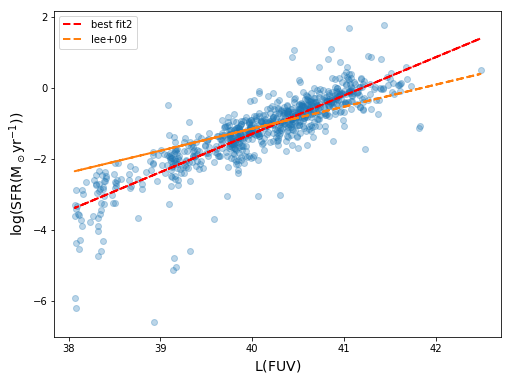

In [7]:
# "This relation is the result of a linear least squares fit of SFR(FUV),
# where L(FUV) has been corrected for internal dust extinction,
# as a function of SFR(Hα), which has not been dust corrected."

xarr = corr_tbl['obs_lumin'].data+nii_ha_corr_factor+filt_corr_factor # L(Hα), not dust corrected
yarr = log_SFR_UV_dustcorr # SFR(FUV) corrected for internal dust extinction

params2, covar2 = curve_fit(line2, xarr, yarr, p0=[0.62,-0.47])
print params2

plt.plot(xarr, yarr, 'o', alpha=0.3)
plt.gcf().set_size_inches(8,6)

plt.plot(xarr, line2(xarr, *params2), 'r--', lw=2, label='best fit2')
plt.plot(xarr, lee09_eqn10(xarr), '--', lw=2, label='lee+09')
plt.xlabel(r'$\rm L(FUV)$', size=14)
plt.ylabel(r'$\rm \log (SFR (M_\odot yr^{-1}))$', size=14)
plt.legend()
plt.show()

In [ ]:
# eventually maybe: retrieve janice's data and plot that and see if things match up?
# so just work on the paper for now...